# ESGF Virtual Aggregation - Demo

Remote data access to Virtual Analysis Ready Data (Virtual ARD) for climate datasets of the [ESGF](https://esgf.llnl.gov/).

## Contents

* [Introduction](#introduction)
  * [Loading the inventory](#loading-the-inventory)
  * [Loading a dataset](#loading-a-dataset)
  * [Query attributes](#query-attributes)
  * [Performing data analysis](#performing-data-analysis)
* [Similarities with other approaches](#similarities-with-other-approaches)
  * [Pangeo CMIP6](#pangeo-cmip6)
  * [Cloud native repositories](#cloud-native-repositories)
  * [ROOCS](#roocs)
  * [ENSO](#enso)
* [Discussion and FAQ](#discussion)

In [1]:
import timeit
import zipfile

import numpy as np
import pandas as pd
import netCDF4
import xarray
import dask
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

dask.config.set(scheduler="processes")

%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 6

# Introduction <a class="anchor" id="introduction"></a>

## Loading the inventory <a class="anchor" id="loading-the-inventory"></a>

Currently, the invetory is a CSV file which can be queried for locating the desired dataset. You may also inspect the [THREDDS catalog](https://hub.ipcc.ifca.es/thredds/catalog/esgeva/catalog.html).

In [2]:
df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/public/inventory.csv")

# Find a dataset
subset = df.query("product == 'ScenarioMIP' & model == 'CNRM-CM6-1' & experiment == 'ssp245' & table == 'day' & variable == 'tas' & version == 'v20190410'")

# See available data nodes
subset[["location", "replica"]]

/tmp/ipykernel_27747/1605771671.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.ipcc.ifca.es/thredds/fileServer/public/inventory.csv")


,location,replica
2124279,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,NaN
2124302,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,aims3.llnl.gov
2124321,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.ceda.ac.uk
2124329,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf.nci.org.au
2124348,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,esgf3.dkrz.de


Once you have located the desired URL for your dataset, save its URL.

In [ ]:
# Select a data node and get the url
url = subset.query("replica.isnull()")["location"].iloc[0]
url

## Loading a dataset <a class="anchor" id="loadingg-a-dataset"></a>

Now that you have an URL, try to load the dataset using [xarray](https://docs.xarray.dev/en/stable/).

In [ ]:
# Use a demo URL for demonstration (see https://hub.ipcc.ifca.es/thredds/catalog/esgeva/demo/catalog.html)
url = "https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/demo/CMIP6_ScenarioMIP_MIROC_MIROC-ES2L_ssp245_3hr_tas_gn_v20210107_esgf-data02.diasjp.net.ncml"

# Load the URL
ds = xarray.open_dataset(url)
ds

### Query attributes <a class="anchor" id="query-attributes"></a>

The ESGF Virtual Aggregation includes metadata of interest for the users. Let's inspect some attributes.

In [ ]:
# Query the size of the dataset on the server side (sum of file sizes on the server
ds.attrs["size_human"] # Note that this might be different from the size in memory

In [ ]:
# View the variant_label (ensemble) coordinate
ds["variant_label"][...]

In [ ]:
# Query the PID handles of the virtual dataset
ds["tracking_id"][:,1].values

## Performing data analysis <a class="anchor" id="performing-data-analysis"></a>

Now that we have loaded the dataset, we can perform data analysis on it. First, let's chunk the dataset to allow scalability through [Dask]().

In [ ]:
dsc = ds.chunk({"variant_label":1, "time": 100})

Now, inspect the structure of the data cube.

In [ ]:
dsc["tas"]

We are ready to perform data analysis of an small subset of the array and plot the results. Note that only the required data is transferred through the networking, involving no file downloads at all.

In [ ]:
bins = [
    np.datetime64('2100-01-01'),
    np.datetime64('2100-03-15'),
    np.datetime64('2100-06-15'),
    np.datetime64('2100-09-15'),
    np.datetime64('2100-12-31')]
da = dsc["tas"].sel(variant_label=[b"r10i1p1f2", b"r11i1p1f2"], time=slice("21000101", None))

In [ ]:
da

In [ ]:
%time results = da.groupby_bins("time", bins).mean().compute(nworkers=4)

In [ ]:
plot = results.assign_coords({"time_bins": ["JFM", "MAJ", "JAS", "OND"]}).plot(
    x="lon", y="lat", col="time_bins", row="variant_label",
    add_colorbar=True,
    cmap="coolwarm",
    cbar_kwargs={"shrink": .6},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

# Similarities with other approaches <a class="anchor" id="similarities-with-other-approaches"/>

Currently there is a strong emphasis in providing capabilities for easy data analysis of climate data, due to productivity that can be achieved. The ESGF Virtual Aggregation is one of these attemps and now we discuss how it compares to different approaches from the community.

## Pangeo CMIP6 <a class="anchor" id="pangeo-cmip6"/>

People from Pangeo are setting up cloud repositories for CMIP6 ARCO (Analysis Ready Cloud Optimized) datasets from ESGF. While the performance of these repositories is much superior to the data nodes of the ESGF, the cost of implementing these repositories is huge, due to the cost of duplicating the data. The ESGF Virtual Aggregation is less performant than cloud repositories but it is also much cheaper to build.

The ESGF Virtual Aggregation should be seen as an intermediate approach between the current state of the ESGF federation and more ground-breaking solutions like cloud repositories. Its main purpose is to show the compute capabilites that can be reached building on top of the existing federation.

[Here](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html) you can find the basic example for data search and load from the Pangeo repository. We try to reproduce this here using the ESGF Virtual Aggregation.

In [ ]:
subset = df.query("product == 'CMIP' & model == 'CESM2' & experiment == 'historical' & table == 'Amon' & variable == 'tas' & version == 'v20190311'")
subset

In [ ]:
url = subset.iloc[0]["location"]
ds = xarray.open_dataset(url).chunk({"time": 100})
ds

Plot a map from a specific date.

In [ ]:
ds.tas.sel(time='1950-01', variant_label=b"r9i1p1f1").squeeze().plot()

Create a timeseries of global-average surface air temperature.

In [ ]:
areacella = xarray.open_dataset("http://esgf-data04.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r9i1p1f1/fx/areacella/gn/v20190311/areacella_fx_CESM2_historical_r9i1p1f1_gn.nc")
areacella

In [ ]:
total_area = areacella["areacella"].sum(dim=["lon", "lat"])
ta_timeseries = (ds["tas"].sel(variant_label=b"r9i1p1f1") * areacella["areacella"]).sum(dim=["lon", "lat"]) / total_area
ta_timeseries

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [ ]:
%time ta_timeseries.load()

In [ ]:
ta_timeseries.plot(label="monthly")
ta_timeseries.rolling(time=12).mean().plot(label="12 month rolling mean")
plt.legend()
plt.title("Global Mean Surface Air Temperature")

## Cloud native repositories <a class="anchor" id="cloud-native-repositories"/>

This work is a bridge between the current state of the federation and more elaborated [ETL](https://es.wikipedia.org/wiki/Extract,_transform_and_load) attemps such as [Google CMIP6](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html) from [Pangeo](https://pangeo.io/). The later is a much more expensive workflow that requires duplication of the datasets into a cloud provider, which in advantage offers much more scalable data service compared to the "best effort" basis of the ESGF data nodes. Also, the ESGF Virtual Aggregation offers a higher level Analysis Ready Dataset by adding the `ensemble` dimension to the variables (see the [Virtual Aggregation file](https://hub.ipcc.ifca.es/thredds/fileServer/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_gr_v20190410/replicas/aims3.llnl.gov/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_tas_gr_v20190410_aims3.llnl.gov.ncml)).

The ESGF Virtual Aggregation could act as an intermediate between the ESGF and cloud native repositories. Because ESGF Virtual Aggregation is much cheaper to run (since it only reads metadata from the ESGF distributed index), cloud repositories using cloud optimized formats (Zarr) can be created much easier. For example:

In [ ]:
# Open a dataset from the ESGF Virtual Aggregation
ds = xarray.open_dataset("https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/demo/CMIP6_ScenarioMIP_MIROC_MIROC-ES2L_ssp245_3hr_tas_gn_v20210107_esgf-data02.diasjp.net.ncml").chunk({"variant_label": 1, "time": 736})

# Extract a subset from the ESGF Virtual Aggregation
subset = ds.sel(variant_label=[b"r10i1p1f2", b"r11i1p1f2", b"r12i1p1f2"], time=slice("21000601", "21000831"))
subset["tas"]

In [ ]:
!rm -rf test.zarr

In [ ]:
# Dump to a cloud native repository
subset.to_zarr("test.zarr")

## ROOCS <a class="anchor" id="roocs"/>

[ROOCS](https://github.com/roocs) is a project to develop data services in support of the Copernicus Climate Change Service (C3S). ROOCS is providing a collection of tools to provide data-aware processing services of climate projections from CMIP6, CMIP5 and CORDEX.

The main focus of the service is to reduce the volumes of data transferred by providing data-reduction processes that can be invoked directly from the C3S Climate Data Store (CDS).

[Here](https://nbviewer.org/github/roocs/rooki/blob/master/notebooks/demo/demo-rooki-concat-with-average-cmip6-decadal.ipynb) you can find an example of a ROOCS workflow. We try to reproduce the workflow here using the ESGF Virtual Aggregation.

In [ ]:
# CMIP6.DCPP.MOHC.HadGEM3-GC31-MM.dcppA-hindcast.s1995-r1i1p1f2.Amon.tas.gn.v20200417
subset = df.query("product == 'DCPP' & model == 'HadGEM3-GC31-MM' & experiment == 'dcppA-hindcast' & subexperiment == 's1995' & table == 'Amon' & variable == 'tas' & version == 'v20200417'")
subset

In [ ]:
url = subset.query("replica == 'esgf.nci.org.au'").iloc[0]["location"]
url

In [ ]:
ds = xarray.open_dataset(url).chunk({"variant_label": 1, "time": 75})
ds["tas"]

In [ ]:
%time a = ds["tas"].mean(["lat", "lon"]).compute()

In [ ]:
a.plot.line(x="time")

## ENSO example <a class="anchor" id="enso"/>


https://github.com/esgf2-us/esgf-cookbook/blob/main/notebooks/enso-globus.ipynb

In [3]:
import cf_xarray
import hvplot.xarray

In [4]:
subset = pd.concat([
    df.query("model != 'CESM2-WACCM' & product == 'CMIP' & experiment == 'historical' & variable == 'areacello' & institution == 'NCAR' & replica.isnull()").groupby("model").last(),
    df.query("model != 'CESM2-WACCM' & product == 'CMIP' & experiment == 'historical' & variable == 'tos' & table == 'Omon' & institution == 'NCAR' & replica.isnull()").groupby("model").last(),
])

subset

,location,project,product,institution,experiment,subexperiment,table,variable,grid_label,version,replica
model,,,,,,,,,,,
CESM2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Ofx,areacello,gr,v20190514,None
CESM2-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Ofx,areacello,gr,v20200226,None
CESM2-WACCM-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Ofx,areacello,gr,v20200226,None
CESM2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Omon,tos,gr,v20190514,None
CESM2-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Omon,tos,gr,v20200226,None
CESM2-WACCM-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Omon,tos,gr,v20200226,None


In [10]:
areacello = subset.query("variable == 'areacello'")
tos = subset.query("variable == 'tos'")

ds = xarray.merge([
    xarray.concat([xarray.open_dataset(url)["areacello"].isel(variant_label=0).sel(lat=slice(-5,5), lon=slice(190,240))
                   for url in areacello["location"]], areacello.index),
    xarray.concat([xarray.open_dataset(url)["tos"].isel(variant_label=0).sel(lat=slice(-5,5), lon=slice(190,240))
                   for url in tos["location"]], tos.index)
]).drop_vars('variant_label')

ds

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (lat: 10, lon: 50, model: 3, time: 1980)
Coordinates:
  * lat        (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
  * model      (model) object 'CESM2' 'CESM2-FV2' 'CESM2-WACCM-FV2'
  * time       (time) object 1850-01-15 13:00:00.000007 ... 2014-12-15 12:00:00
Data variables:
    areacello  (model, lat, lon) float64 1.233e+10 1.233e+10 ... 1.233e+10
    tos        (model, time, lat, lon) float32 29.27 29.19 29.1 ... 30.47 30.43
Attributes: (12/18)
    _CoordinateAxes:  variant_label lat lon
    cell_methods:     area: sum
    comment:          TAREA
    description:      Cell areas for any grid used to report ocean variables ...
    frequency:        fx
    id:               areacello
    ...               ...
    time_label:       None
    time_title:       No temporal dimensions ... fixed field
    title:            Grid-Cell Area for Ocean Variables
    type:             real
    units:            m2
    variable_id:      areacello

In [11]:
def calculate_enso(ds):

    # Subset the El Nino 3.4 index region
    dso = ds.where(
        (ds.cf["latitude"] < 5) &
        (ds.cf["latitude"] > -5) &
        (ds.cf["longitude"] > 190) &
        (ds.cf["longitude"] < 240),
        drop=True)

    # Calculate the monthly means
    gb = dso.tos.groupby('time.month')

    # Subtract the monthly averages, returning the anomalies
    tos_nino34_anom = gb - gb.mean(dim='time')

    # Determine the non-time dimensions and average using these
    non_time_dims = set(tos_nino34_anom.dims)
    non_time_dims.remove(ds.tos.cf["T"].name)
    weighted_average = tos_nino34_anom.weighted(ds["areacello"]).mean(dim=list(non_time_dims))

    # Calculate the rolling average
    rolling_average = weighted_average.rolling(time=5, center=True).mean()
    std_dev = weighted_average.std()
    return rolling_average / std_dev

def add_enso_thresholds(da, threshold=0.4):

    # Conver the xr.DataArray into an xr.Dataset
    ds = da.to_dataset()

    # Cleanup the time and use the thresholds
    try:
        ds["time"]= ds.indexes["time"].to_datetimeindex()
    except:
        pass
    ds["tos_gt_04"] = ("time", ds.tos.where(ds.tos >= threshold, threshold).data)
    ds["tos_lt_04"] = ("time", ds.tos.where(ds.tos <= -threshold, -threshold).data)

    # Add fields for the thresholds
    ds["el_nino_threshold"] = ("time", np.zeros_like(ds.tos) + threshold)
    ds["la_nina_threshold"] = ("time", np.zeros_like(ds.tos) - threshold)

    return ds

enso_index = add_enso_thresholds(calculate_enso(ds).compute())
enso_index

/tmp/ipykernel_27747/2821268070.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"]= ds.indexes["time"].to_datetimeindex()


<xarray.Dataset>
Dimensions:            (time: 1980)
Coordinates:
  * time               (time) datetime64[ns] 1850-01-15T13:00:00.000007 ... 2...
    month              (time) int64 1 2 3 4 5 6 7 8 9 ... 4 5 6 7 8 9 10 11 12
Data variables:
    tos                (time) float64 nan nan -1.017 -0.8439 ... 1.347 nan nan
    tos_gt_04          (time) float64 0.4 0.4 0.4 0.4 ... 1.129 1.347 0.4 0.4
    tos_lt_04          (time) float64 -0.4 -0.4 -1.017 ... -0.4 -0.4 -0.4
    el_nino_threshold  (time) float64 0.4 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    la_nina_threshold  (time) float64 -0.4 -0.4 -0.4 -0.4 ... -0.4 -0.4 -0.4

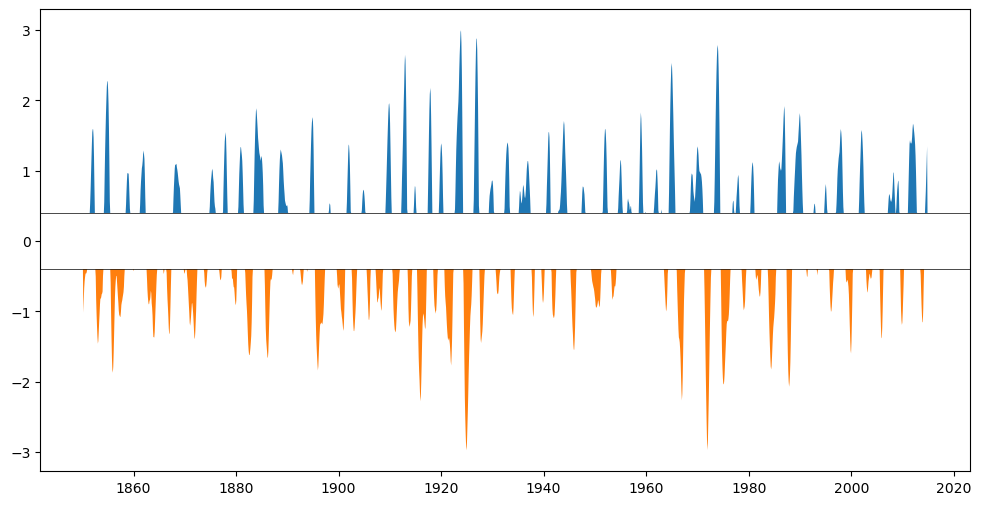

In [12]:
fig, ax = plt.subplots(1,1)

plt.axhline(y=0.4, color='black', linestyle='-', linewidth=.5)
plt.axhline(y=-0.4, color='black', linestyle='-', linewidth=.5)

plt.fill_between(enso_index["time"], enso_index["tos_gt_04"].data, 0.4)
plt.fill_between(enso_index["time"], enso_index["tos_lt_04"].data, -0.4)

In [ ]:
# Export the data
# ds.to_netcdf("enso.nc")

# Discussion <a class="anchor" id="discussion"></a>

## How it works?

**ALL** ESGF file metada is queried into a local database and from this database, small metadata [NcML]() files are created. The NcML files allow to merge multiple netCDF files into a single dataset. netCDF files from the federation are referenced by their OPeNDAP endpoint, thus no data movement is needed from the original data nodes.

```xml
<aggregation type="joinNew" dimName="variant_label">
    <variableAgg name="tas" />
        <netcdf coordValue="r2i1p1f2">
            <aggregation type="joinExisting" dimName="time">
                <netcdf location="http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r2i1p1f2/day/tas/gr/v20190410/tas_day_CNRM-CM6-1_ssp245_r2i1p1f2_gr_20150101-21001231.nc" ncoords="31411"/>
            </aggregation>
        </netcdf>
        <netcdf coordValue="r3i1p1f2">
            <aggregation type="joinExisting" dimName="time">
                <netcdf location="http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r3i1p1f2/day/tas/gr/v20190410/tas_day_CNRM-CM6-1_ssp245_r3i1p1f2_gr_20150101-21001231.nc" ncoords="31411"/>
            </aggregation>
        </netcdf>
</aggregation>
```

## Some ESGF Virtual Aggregation datasets, specially from the ensemble aggregation, take forever to open, why?

One of the main drawbacks of the current implementation of the ESGF Virtual Aggregation is that it takes a lot of time to open virtual datasets that reference lots (more than 100) files. Because no information is available in the ESGF index about the time coordinate, there is no way to tell the virtual dataset the size of the time dimension. Thus, the virtual dataset tries to obtain this from the files but this involves a huge amount of HTTP requests because it needs to query all the files in the virtual dataset. If only information about the size of the time dimension and the values from the time coordinate were available in the ESGF index, this performance issue would be solved.

## How does OPeNDAP compare to Zarr for remote data analysis?

In summary, Zarr is more efficient for remote data analysis. When requesting a piece of data from a Zarr store, the chunks travel compressed to the client. On the other hand, OPeNDAP servers uncompress the chunks from netCDF files on the server and send the data uncompressed to the client, making the transfer more inefficient.

## How does OPeNDAP compare to server side computing (eg: ROOCS)?

Both OPeNDAP and cloud native data stores aim to provide remote data analysis capabilities. Because the data is required to travel through the Internet, I/O performance is far from ideal. Server side computing such as ROOCS receive the compute request on the server and compute the result near to the data with much faster I/O. In general, remote data analysis serves for exploratory tasks and if fast I/O is needed, compute resources should be bought/requested in the infrastructure where the data resides.

## How does NcML compare to Kerchunk?

While Kerchunk focuses on creating a metada file to locate chunks of data in different formats, it can be use to create virtual datasets too (see [this](https://fsspec.github.io/kerchunk/tutorial.html#combine-multiple-kerchunked-datasets-into-a-single-logical-aggregate-dataset)). NcML serves a similar purpose but it works with CDM compatible datasets (see [netCDF-java CDM](https://docs.unidata.ucar.edu/netcdf-java/current/userguide/common_data_model_overview.html)).

## Does OPeNDAP scale?

OPeNDAP is provided by the [THREDDS Data Server]() in ESGF data nodes. The TDS is a java web application and its ability to scale is the same as any other java web application. If deployed in a single application server, scalibility is limited to the single machine. If a kubernetes clustes is available to spawm multiple application servers, then it can scale and provide more performance.

## How are netCDF files distributed between NcMLs?

In [ ]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1, figsize=(8, 4))

    with zipfile.ZipFile("ncml_dist.csv.zip", "r") as zip_file:
        df = pd.read_csv(zip_file.namelist()[0], names=["name", "count"], skiprows=1)

    bins = [0, 1, 5, 10, 100, 1000, df["count"].max()]
    cuts = pd.cut(df["count"], bins=bins).value_counts(sort=False)
    cuts.plot.bar(rot=0, color="b", ax=ax)
    ax.set_xticklabels(["<={}\n{}%".format(c.right, round(v/len(df)*100,2)) for c,v in zip(cuts.index.categories, cuts.values)])

## Why is the time variable a problem in ESGF?

In HDF5, chunks are stored in a B-Tree and very small values make the B-Tree unnecessary large. NetCDF files in ESGF usually use a chunk size of (1,) for the time coordinate.

In [ ]:
sizes = [256, 512, 1024, 2048, 4096, 8192]
results = []

def test(dset):
    return dset[...].mean()

for size in sizes:
    with netCDF4.Dataset("test.nc", "w") as f:
        f.createDimension("time", size)
        f.createVariable("time1", "f8", ("time",))
        f.createVariable("time2", "f8", ("time",), chunksizes=(1,))

        f["time1"][...] = list(range(size))
        f["time2"][...] = list(range(size))

    with netCDF4.Dataset("test.nc", "r") as f:
        results.append(timeit.timeit(lambda : test(f["time1"]), number=100))
        results.append(timeit.timeit(lambda : test(f["time2"]), number=100))

plt.plot(sizes, results[0::2], '--bo', label="Contiguous")
plt.plot(sizes, results[1::2], '--ro', label="Chunksizes = 1")
plt.legend()
plt.xlabel("Size of the time dimension")
plt.ylabel("Time to load the time values")
plt.title("Load time for sizes [256, 512, 1024, 2048, 4096, 8192]")